In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path
from glob import glob
from datetime import datetime
import sys
sys.path.append('../../../spicy-snow/')

from spicy_snow.processing.snow_index import calc_delta_cross_ratio, calc_delta_gamma, \
    clip_delta_gamma_outlier, calc_snow_index, calc_snow_index_to_snow_depth
from spicy_snow.processing.wet_snow import id_newly_wet_snow, id_wet_negative_si, \
    id_newly_frozen_snow, flag_wet_snow
from spicy_snow.retrieval import retrieval_from_parameters

from dask.distributed import Client


In [2]:
client = Client(local_directory='/tmp', processes=False)
client

/home/eric/miniconda3/envs/spicy_snow_env/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43195 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://172.29.231.250:43195/status,
Dashboard: http://172.29.231.250:43195/status,Workers: 1
Total threads: 16,Total memory: 15.49 GiB
Status: running,Using processes: False
Comm: inproc://172.29.231.250/24431/1,Workers: 1
Dashboard: http://172.29.231.250:43195/status,Total threads: 16
Started: Just now,Total memory: 15.49 GiB
Comm: inproc://172.29.231.250/24431/4,Total threads: 16
Dashboard: http://172.29.231.250:34633/status,Memory: 15.49 GiB
Nanny: None,


In [3]:
files = sorted(glob('spicy_s1_stacks/*.nc'))


f = files[1]
start_year = 2019
start_year = 2020

ds_name = f.split('stacks/')[-1].split('.')[0]
print(datetime.now(), f' -- starting {ds_name}')

    # Open dataset 
ds_ = xr.open_dataset(f).load()
dataset = ds_[['s1','deltaVV','ims','fcf','lidar-sd']]
td = abs(pd.to_datetime(dataset.time) - pd.to_datetime(dataset.attrs['lidar-flight-time']))
closest_ts_idx = np.where(td == td.min())[0][0]
closest_ts = dataset.time[closest_ts_idx]

a = 2.5
b = 0.2
c = 0.55

2023-09-06 15:36:25.693005  -- starting Banner_2021-03-15


In [4]:
ds = retrieval_from_parameters(dataset,A=a,B=b,C=c,wet_SI_thresh=0,freezing_snow_thresh=1,wet_snow_thres=-2)

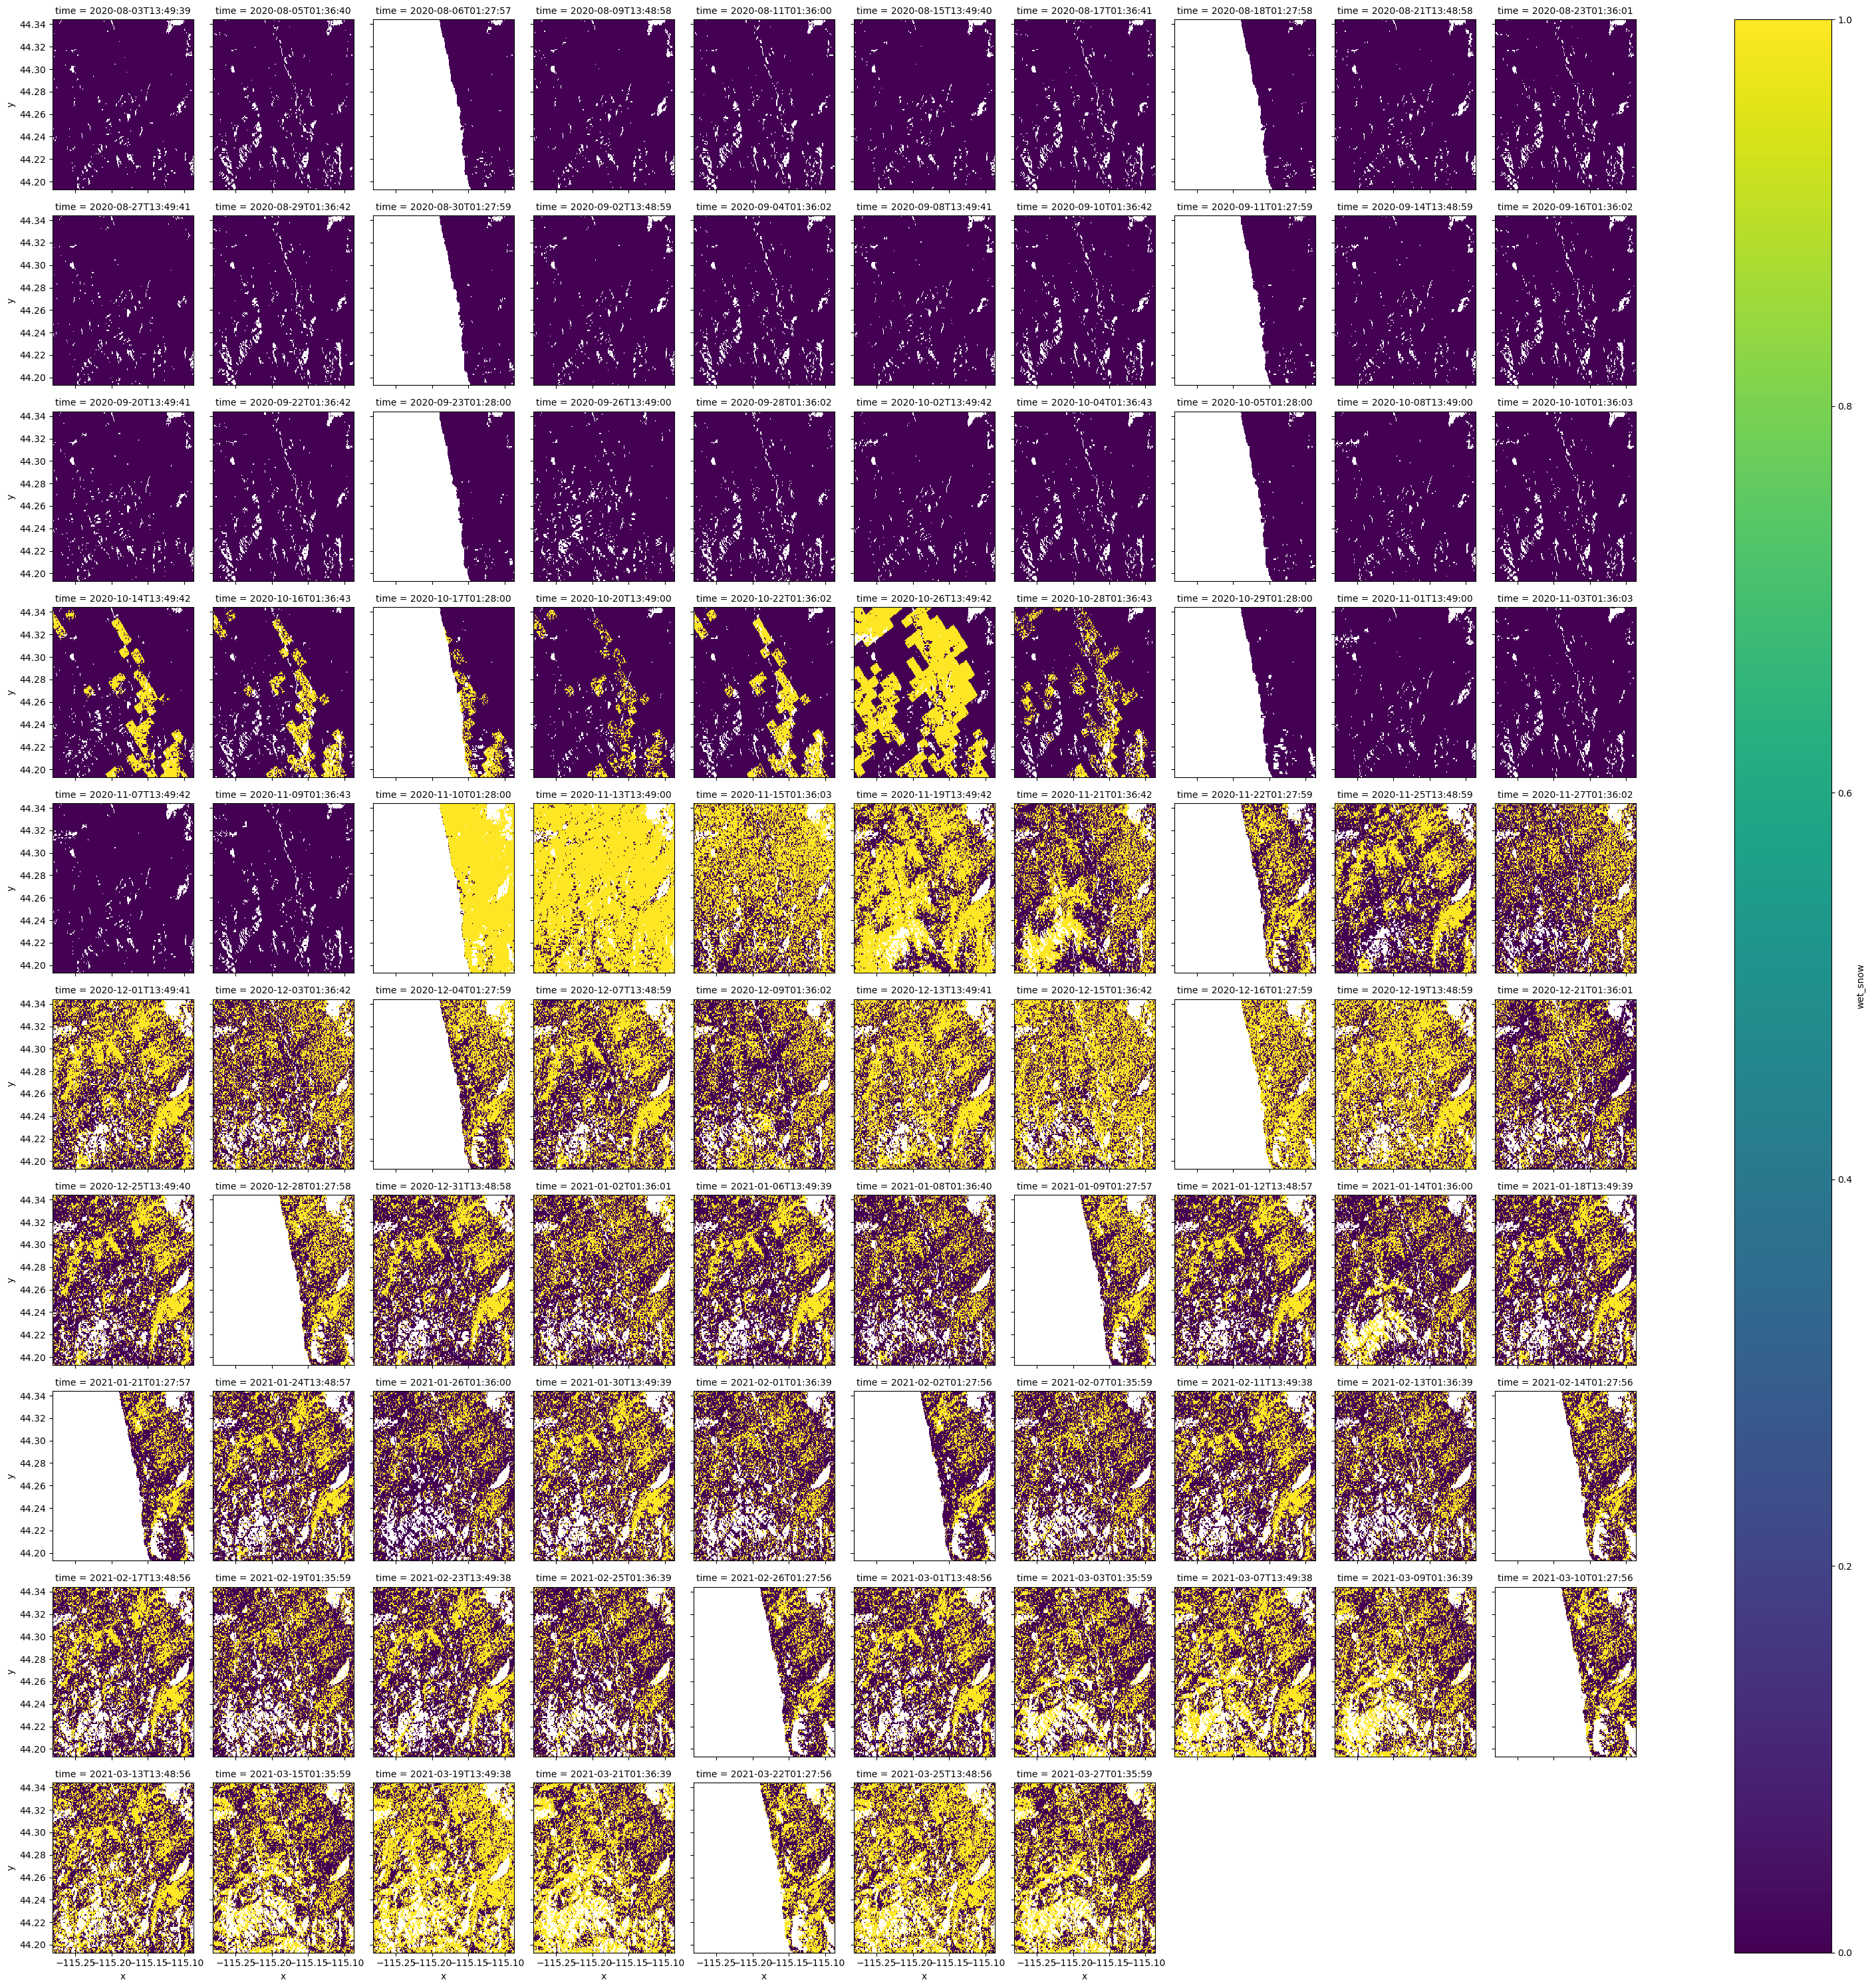

In [5]:
ds['wet_snow'].plot(col='time',col_wrap=10)
#ds['wet_flag'].plot(col='time',col_wrap=10)
#ds['alt_wet_flag'].plot(col='time',col_wrap=10)
#ds['freeze_flag'].plot(col='time',col_wrap=10)
#ds['perma_wet'].plot(col='time',col_wrap=10)

#ds['snow_index'].plot(col='time',col_wrap=10)


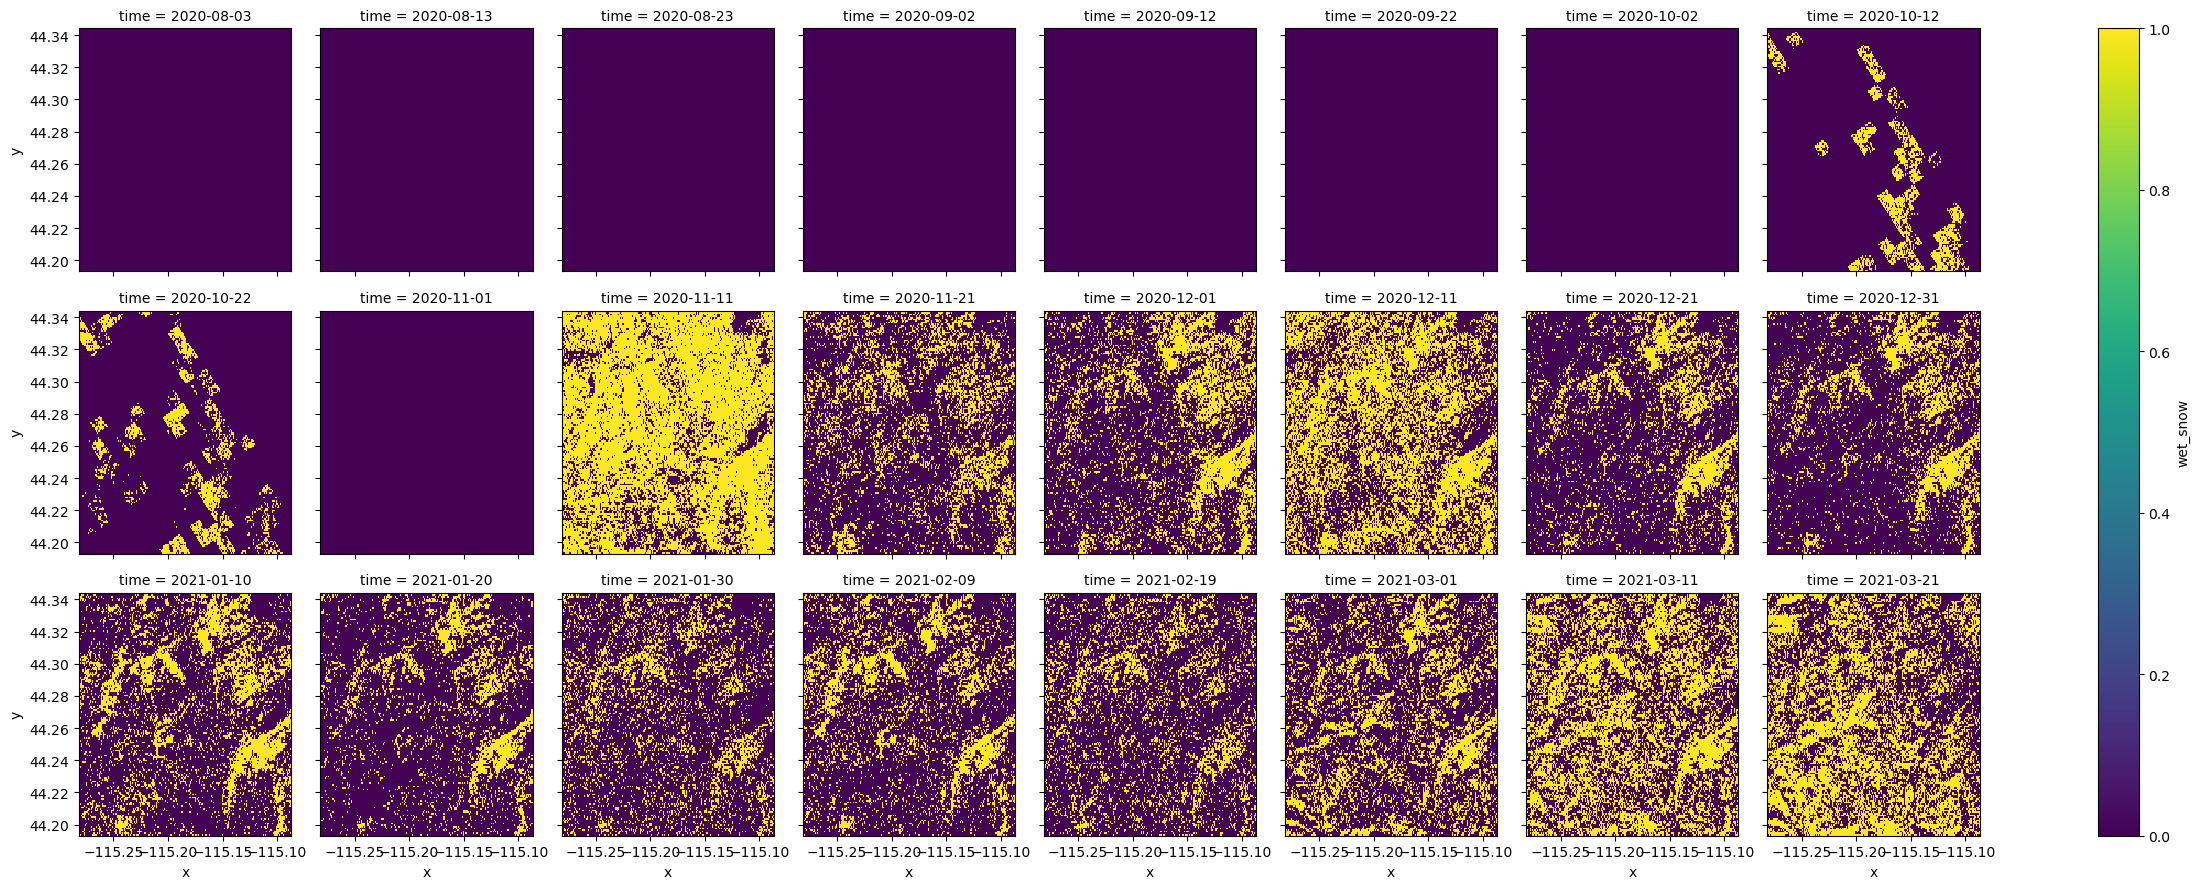

In [6]:
ds_resampled = ds['wet_snow'].resample(time='10D').median(dim='time')
ds_resampled = ds_resampled > 0.5
ds_resampled.plot(col='time',col_wrap=8)

In [7]:
code = '312_ID_SNTL'
snotel_data = pd.read_parquet(f'https://github.com/scottyhq/snotel/raw/main/parquet/{code}.parquet')
snotel_TAVG = snotel_data['TAVG'].loc[slice(f'{start_year}-08',f'{start_year+1}-04')]

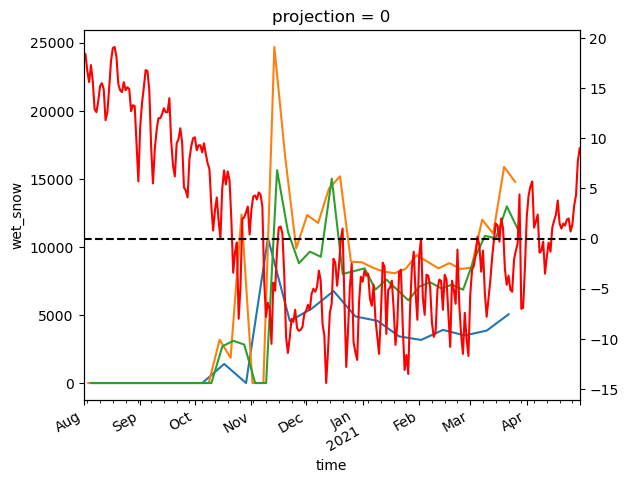

In [8]:
f,ax=plt.subplots()
for orbit in np.unique(ds['relative_orbit']):
    ds_ws = ds['wet_snow']
    ds_orbit = ds_ws[ds_ws['relative_orbit']==orbit]
    ds_orbit.sum(dim=['x','y']).plot(ax=ax)

T_ax = ax.twinx()
snotel_TAVG.plot(ax=T_ax, color='red')
T_ax.axhline(0,color='black',linestyle='--')



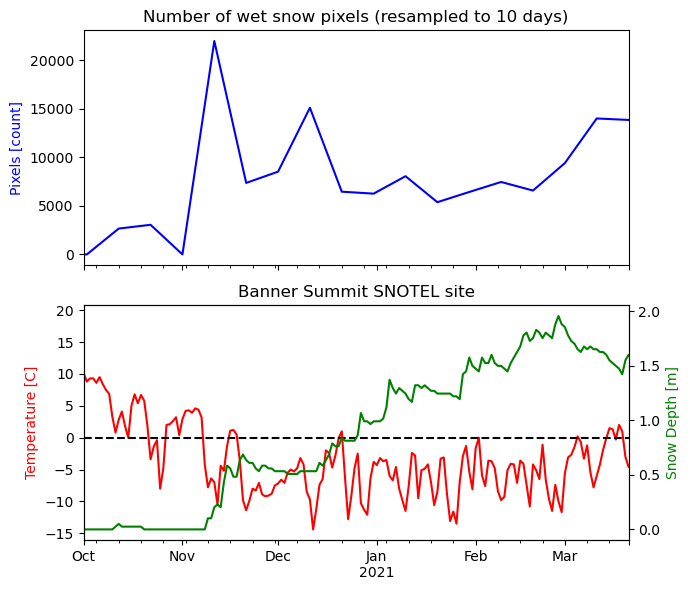

In [9]:
f,ax=plt.subplots(2,1,figsize=(7,6),sharex=True)
PRCP_ax = ax[1].twinx()
ds_resampled.sum(dim=['x','y']).plot(ax=ax[0],color='blue')
ax[0].set_xlim([pd.to_datetime(f'{start_year}-10'),pd.to_datetime(f'{start_year+1}-03-21')])

snotel_TAVG.plot(ax=ax[1], color='red')

ax[1].axhline(0,color='black',linestyle='--')
snotel_data['SNWD'].loc[slice(f'{start_year}-08',f'{start_year+1}-04')].plot(ax=PRCP_ax,color='green')
ax[1].set_xlim([pd.to_datetime(f'{start_year}-10'),pd.to_datetime(f'{start_year+1}-03-21')])

ax[0].set_title('Number of wet snow pixels (resampled to 10 days)')
ax[0].set_ylabel('Pixels [count]')
ax[0].set_xlabel('')
ax[1].set_xlabel('')
ax[1].set_title('Banner Summit SNOTEL site')
ax[1].set_ylabel('Temperature [C]')
PRCP_ax.set_xlabel('')
PRCP_ax.set_ylabel('Snow Depth [m]')

ax[0].yaxis.label.set_color('blue')
ax[1].yaxis.label.set_color('red')
PRCP_ax.yaxis.label.set_color('green')


plt.tight_layout()

f.savefig('figures/wet_snow_and_snotel.png',dpi=600)

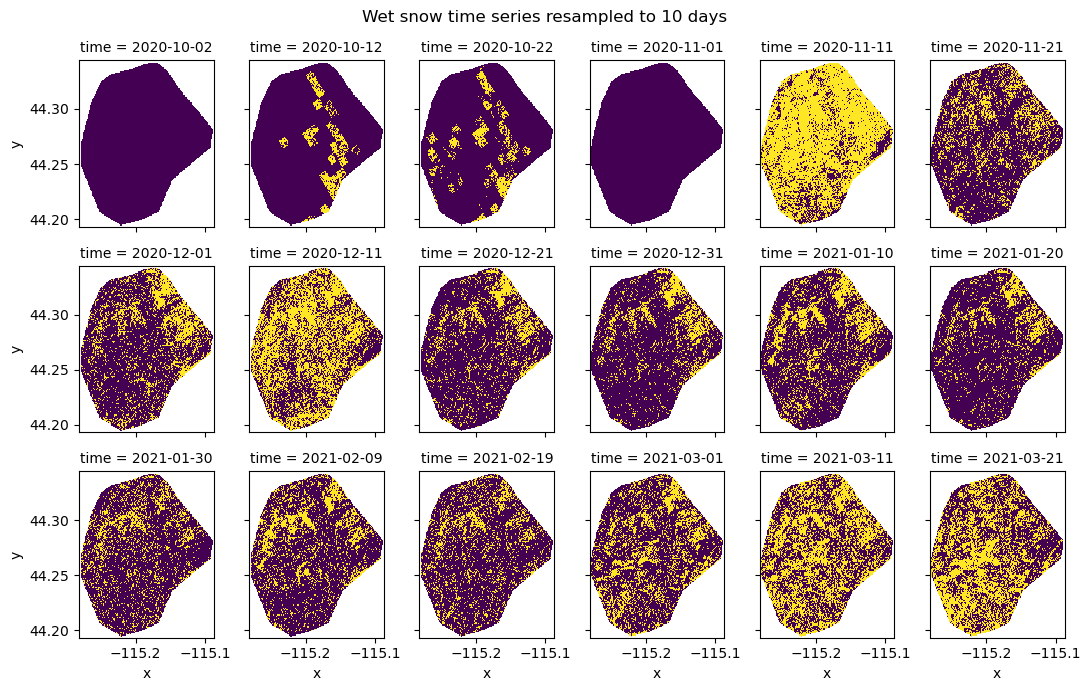

In [10]:
ds_resampled = ds['wet_snow'].resample(time='10D').median(dim='time')
ds_resampled = ds_resampled > 0.5
f = ds_resampled.where(~ds['lidar-sd'].isnull()).sel(time=slice(f'{start_year}-10',f'{start_year+1}-03-21')).plot(col='time',col_wrap=6, add_colorbar=False)
f.fig.suptitle('Wet snow time series resampled to 10 days')
f.fig.set_size_inches(11,7)

f.fig.tight_layout()
f.fig.savefig('figures/wet_snow_ts_10days.png',dpi=600)